# XGBoost
The purpose of this notebook is to use XGBoost for predicting hourly bike demand by station.

In [5]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn import datasets, svm

## Data Analysis and Exploration

In [6]:
# Import data
df = pd.read_csv('data/bike_data_clean.csv')
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df.head()

,num_trips,start_datetime,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour
0,1,2013-06-01,72,1542.0,False,5,0
1,3,2013-06-01,79,947.0,False,5,0
2,1,2013-06-01,83,351.0,False,5,0
3,1,2013-06-01,143,915.0,False,5,0
4,1,2013-06-01,146,1181.0,False,5,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135263 entries, 0 to 135262
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   num_trips          135263 non-null  int64         
 1   start_datetime     135263 non-null  datetime64[ns]
 2   start_station_id   135263 non-null  int64         
 3   avg_trip_duration  135263 non-null  float64       
 4   is_weekend         135263 non-null  bool          
 5   day_of_week        135263 non-null  int64         
 6   hour               135263 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4)
memory usage: 6.3 MB


In [5]:
df.corr()

,num_trips,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour
num_trips,1.000000,-0.040211,-0.005261,-0.065386,0.076828,0.153500
start_station_id,-0.040211,1.000000,0.001049,0.000914,-0.000859,0.006623
avg_trip_duration,-0.005261,0.001049,1.000000,-0.005738,0.000371,-0.000180
is_weekend,-0.065386,0.000914,-0.005738,1.000000,-0.827093,-0.003935
day_of_week,0.076828,-0.000859,0.000371,-0.827093,1.000000,-0.009646
hour,0.153500,0.006623,-0.000180,-0.003935,-0.009646,1.000000


In [6]:
df.describe()

,num_trips,start_station_id,avg_trip_duration,day_of_week,hour
count,135263.000000,135263.000000,1.352630e+05,135263.000000,135263.000000
mean,4.137451,455.401063,1.432476e+03,3.259347,13.573002
std,4.090622,403.231032,1.175319e+04,2.020372,5.842530
min,1.000000,72.000000,6.100000e+01,0.000000,0.000000
25%,1.000000,304.000000,6.427500e+02,2.000000,9.000000
50%,3.000000,393.000000,9.230000e+02,3.000000,14.000000
75%,5.000000,479.000000,1.289686e+03,5.000000,18.000000
max,58.000000,3020.000000,3.876479e+06,6.000000,23.000000


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


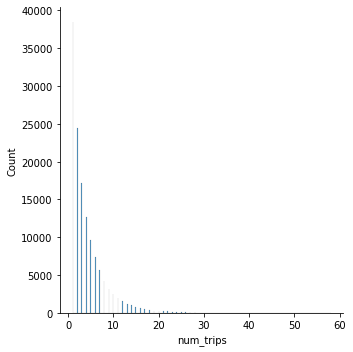

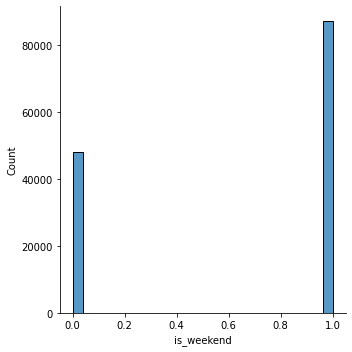

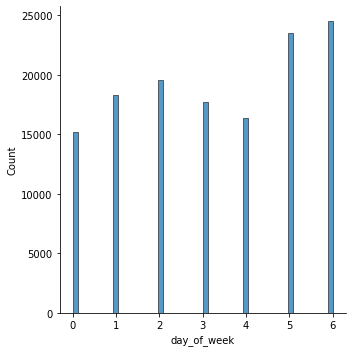

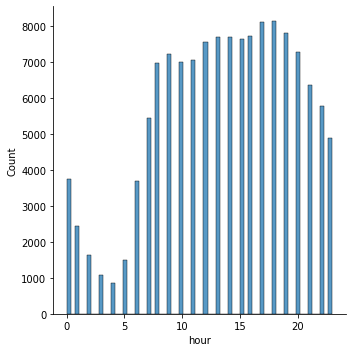

In [7]:
# Plot distribution of num_trips, is_weekend, day_of_week, and hour
sns.displot(df['num_trips'])
sns.displot(df['is_weekend'])
sns.displot(df['day_of_week'])
sns.displot(df['hour'])

Note that num_trips does not look like a Gaussian distribution, so lets transform to a logarithmic distribution.

In [11]:
#df['num_trips_log'] = np.log1p(df['num_trips'])
#df = df.reindex(columns=['num_trips', 'num_trips_log', 'start_datetime', 'start_station_id', 'avg_trip_duration', 'is_weekend', 'day_of_week', 'hour'])
#df.head()

,num_trips,num_trips_log,start_datetime,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour
0,1,0.693147,2013-06-01,72,1542.0,False,5,0
1,3,1.386294,2013-06-01,79,947.0,False,5,0
2,1,0.693147,2013-06-01,83,351.0,False,5,0
3,1,0.693147,2013-06-01,143,915.0,False,5,0
4,1,0.693147,2013-06-01,146,1181.0,False,5,0


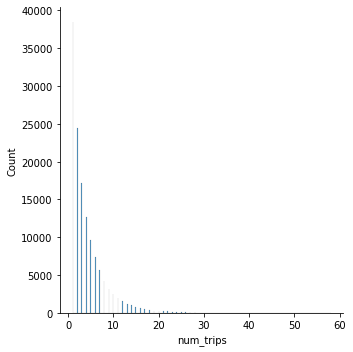

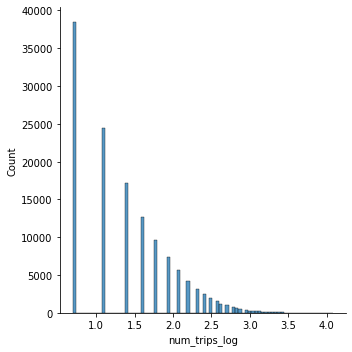

In [9]:
# Plot num_trips_log distribution
sns.displot(df['num_trips'])
sns.displot(df['num_trips_log'])

While num_trips_log still does not look Gaussian, lets test the ML model for predicting both num_trips and num_trips_log

Now lets plot the num_trips over time

<AxesSubplot:xlabel='start_datetime', ylabel='num_trips'>

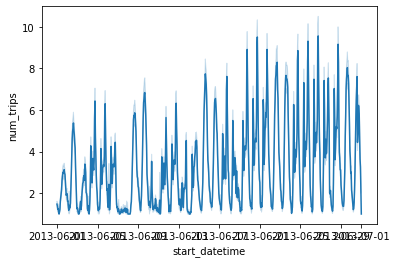

In [10]:
sns.lineplot(data=df, x='start_datetime', y='num_trips')

<AxesSubplot:xlabel='start_datetime', ylabel='num_trips_log'>

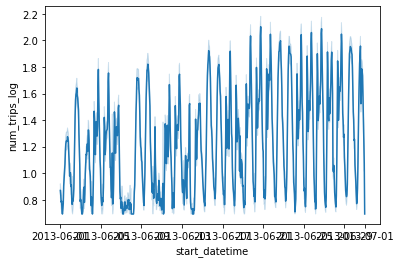

In [11]:
sns.lineplot(data=df, x='start_datetime', y='num_trips_log')

The number of trips appear to increase over the month, though this is less noticeable in the num_trips_log graph.

<AxesSubplot:xlabel='hour', ylabel='num_trips'>

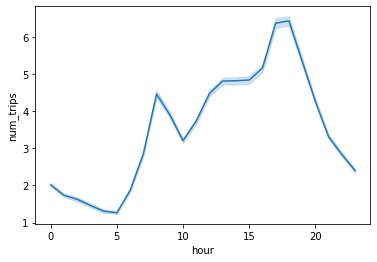

In [12]:
sns.lineplot(data=df, x='hour', y='num_trips')

<AxesSubplot:xlabel='hour', ylabel='num_trips_log'>

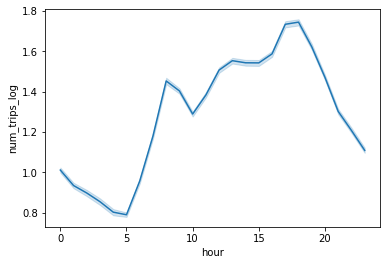

In [13]:
sns.lineplot(data=df, x='hour', y='num_trips_log')

The distribution of num_trips and num_trips_log by hour appears approximately the same. Note that this distribution appears to show that day hours and night hours are somewhat of a splitting point. Between approximately 7am and 9pm

In [14]:
# Plot correlation matrix
df.corr()

,num_trips,num_trips_log,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour
num_trips,1.000000,0.921484,-0.040211,-0.005261,-0.065386,0.076828,0.153500
num_trips_log,0.921484,1.000000,-0.059509,-0.006495,-0.067546,0.081862,0.187580
start_station_id,-0.040211,-0.059509,1.000000,0.001049,0.000914,-0.000859,0.006623
avg_trip_duration,-0.005261,-0.006495,0.001049,1.000000,-0.005738,0.000371,-0.000180
is_weekend,-0.065386,-0.067546,0.000914,-0.005738,1.000000,-0.827093,-0.003935
day_of_week,0.076828,0.081862,-0.000859,0.000371,-0.827093,1.000000,-0.009646
hour,0.153500,0.187580,0.006623,-0.000180,-0.003935,-0.009646,1.000000


<AxesSubplot:>

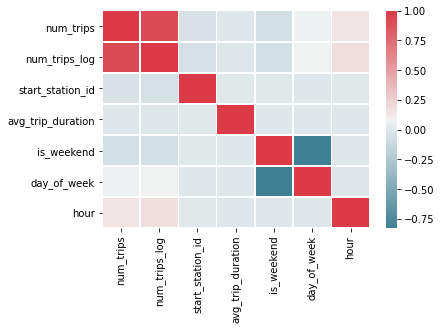

In [15]:
# Plot heatmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=cmap, linewidths=0.5)

Note that is_weekend and day_of_week are correlated. We should likely choose just one of them, but we will test this out with the XGBoost model and importance scores.

## Feature Engineering

Because hour is a cyclical feature, we will encode it using cosine and sine

In [9]:
# Encode time series with cyclical features
df['hour_sin'] = np.sin((2 * np.pi * df['hour']) / max(df['hour']))
df['hour_cos'] = np.cos((2 * np.pi * df['hour']) / max(df['hour']))
df.drop(columns=['start_datetime'], inplace=True)
df

,num_trips,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour,hour_sin,hour_cos
0,1,72,1542.000000,False,5,0,0.000000e+00,1.0
1,3,79,947.000000,False,5,0,0.000000e+00,1.0
2,1,83,351.000000,False,5,0,0.000000e+00,1.0
3,1,143,915.000000,False,5,0,0.000000e+00,1.0
4,1,146,1181.000000,False,5,0,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...
135258,2,2003,725.500000,False,6,23,-2.449294e-16,1.0
135259,3,2004,509.666667,False,6,23,-2.449294e-16,1.0
135260,2,2008,1086.000000,False,6,23,-2.449294e-16,1.0
135261,1,2022,450.000000,False,6,23,-2.449294e-16,1.0


We previously noticed that bike demand was significantly different during the day and at night. Let's add a is_daytime column with a 1 between the hours of 7am to 9pm

In [10]:
# Add day/night hours
# df['is_daytime'] = (df['hour'] >= 7 and df['hour'] <= 21)
# df.head()
df['is_daytime'] = (df['hour']>=7) & (df['hour']<=21)
df.head()

,num_trips,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour,hour_sin,hour_cos,is_daytime
0,1,72,1542.0,False,5,0,0.0,1.0,False
1,3,79,947.0,False,5,0,0.0,1.0,False
2,1,83,351.0,False,5,0,0.0,1.0,False
3,1,143,915.0,False,5,0,0.0,1.0,False
4,1,146,1181.0,False,5,0,0.0,1.0,False


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135263 entries, 0 to 135262
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   num_trips          135263 non-null  int64  
 1   num_trips_log      135263 non-null  float64
 2   start_station_id   135263 non-null  int64  
 3   avg_trip_duration  135263 non-null  float64
 4   is_weekend         135263 non-null  bool   
 5   day_of_week        135263 non-null  int64  
 6   hour               135263 non-null  int64  
 7   hour_sin           135263 non-null  float64
 8   hour_cos           135263 non-null  float64
 9   is_daytime         135263 non-null  bool   
dtypes: bool(2), float64(4), int64(4)
memory usage: 8.5 MB


## Train XGBoost Model

### Testing Train/Test Sizes

In [11]:
# Split data into X, y, and y_log
X = df.iloc[0:,1:]
y = df.iloc[:,0:1]

Because we are predicting bike demand in the future, we want to train data in the past and test data in the future. Let's test the model with different splits

In [12]:
# Create model
model = xgb.XGBRegressor()

# Test model for different splits
# The test sizes represent approximately 1 week, 2 weeks, and 3 weeks
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for test_size in test_sizes:
    print(f"TEST SIZE: {test_size}", )
    # Test/train for that split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    # For non-scaled counts
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE for predicting counts: %f" % (rmse))

TEST SIZE: 0.25
RMSE for predicting counts: 3.600551
TEST SIZE: 0.5
RMSE for predicting counts: 3.869581
TEST SIZE: 0.75
RMSE for predicting counts: 3.938893


For predicting both counts and the scaled counts, the test size of 0.25 achieved the lowest RMSE and RMLSE.

### Feature Selection

Test features to use in the non-transformed counts model

Thresh=0.069, n=8, RMSE: 3.600551
Thresh=0.086, n=7, RMSE: 3.566647
Thresh=0.088, n=6, RMSE: 3.571752
Thresh=0.104, n=5, RMSE: 3.627475
Thresh=0.131, n=4, RMSE: 3.626722
Thresh=0.155, n=3, RMSE: 4.321752
Thresh=0.162, n=2, RMSE: 4.373879
Thresh=0.206, n=1, RMSE: 4.373879


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

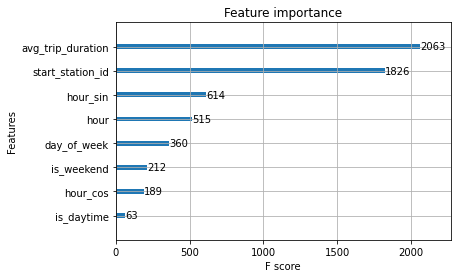

In [23]:
model = xgb.XGBRegressor()
best_split = 0.25

# Counts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features above threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # evaluate model
    select_X_test = selection.transform(X_test)
    preds = selection_model.predict(select_X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("Thresh=%.3f, n=%d, RMSE: %lf" % (thresh, select_X_train.shape[1], rmse))

# Transformed Count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)
xgb.plot_importance(model)

RMSE is reduced the most when is_daytime is excluded from the dataset. Thus, lets remove is_daytime

In [13]:
df.drop(columns=['is_daytime'], inplace=True)

In [14]:
df.head()

,num_trips,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour,hour_sin,hour_cos
0,1,72,1542.0,False,5,0,0.0,1.0
1,3,79,947.0,False,5,0,0.0,1.0
2,1,83,351.0,False,5,0,0.0,1.0
3,1,143,915.0,False,5,0,0.0,1.0
4,1,146,1181.0,False,5,0,0.0,1.0


In [18]:
# Split data into X and y
best_split = 0.25
X = df.iloc[0:,1:]
y = df.iloc[:,0:1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)

### Hyperparameter Tuning

In [19]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [20]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [85]:
# Train max_depth and min_child_weight
# These parameters add constraints on the architectures of the trees, and should be trained together
xgbGridCV = xgb.XGBRegressor()

# max_depth: max number of nodes allowed from root to leaf
# Too large a depth can overfit
# min_child_weight: minimum weight required to create a new node in the tree
# smaller values allow for children to be created with fewer samples
parameters = {
    'max_depth' : [2, 5, 8, 11],
    'min_child_weight' : [2, 5, 8, 11],
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 8, 'min_child_weight': 11}

-3.398 (+/-1.066) for {'max_depth': 2, 'min_child_weight': 2}
-3.398 (+/-1.066) for {'max_depth': 2, 'min_child_weight': 5}
-3.396 (+/-1.066) for {'max_depth': 2, 'min_child_weight': 8}
-3.396 (+/-1.066) for {'max_depth': 2, 'min_child_weight': 11}
-3.139 (+/-0.903) for {'max_depth': 5, 'min_child_weight': 2}
-3.143 (+/-0.907) for {'max_depth': 5, 'min_child_weight': 5}
-3.145 (+/-0.897) for {'max_depth': 5, 'min_child_weight': 8}
-3.142 (+/-0.897) for {'max_depth': 5, 'min_child_weight': 11}
-3.116 (+/-0.791) for {'max_depth': 8, 'min_child_weight': 2}
-3.107 (+/-0.792) for {'max_depth': 8, 'min_child_weight': 5}
-3.102 (+/-0.787) for {'max_depth': 8, 'min_child_weight': 8}
-3.097 (+/-0.791) for {'max_depth': 8, 'min_child_weight': 11}
-3.187 (+/-0.707) for {'max_depth': 11, 'min_child_weight': 2}
-3.161 (+/-0.723) for {'max_depth': 11, 'min_child_weight': 5}
-3.149 (+/-0.723) for {'max_depth': 11, 'min_child_weight': 8}
-3.143 (+

In [37]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")


#     preds = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))

RMSE of preds, y_test: 3.5389842839690786


In [87]:
# Now train n_estimators and learning_rate together

# learning_rate
# weighting factor for the corrections by new trees when adding to the model
# values < 1 has effect of making less corrections for each tree added to the model
# this in turn results in more trees that must be added to the model

# n_estimators
# the number of decision trees

parameters = {
    'max_depth': [8],
    'min_child_weight': [11],
    'n_estimators' : [10, 25, 50, 100, 200, 400, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500}

-5.091 (+/-1.793) for {'learning_rate': 0.0001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 10}
-5.087 (+/-1.794) for {'learning_rate': 0.0001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 25}
-5.08 (+/-1.794) for {'learning_rate': 0.0001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 50}
-5.066 (+/-1.795) for {'learning_rate': 0.0001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 100}
-5.038 (+/-1.797) for {'learning_rate': 0.0001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 200}
-4.983 (+/-1.802) for {'learning_rate': 0.0001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 400}
-4.956 (+/-1.804) for {'learning_rate': 0.0001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500}
-5.066 (+/-1.795) for {'learning_rate': 0.001, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 10}
-5.024 (+/-1.799) for {'learning_rat

In [19]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")


#     preds = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))

RMSE of preds, y_test: 3.494576124826666


In [20]:
# Now train subsample and colsample_bytree - 
# these control the sampling of the dataset that is done at each boosting round
# They make it less likely to overfit to a single sample or feature

#subsample - fraction of observations to subsample at each step
# colsample_bytree - fraction of features (the columns) to use

parameters = {
    'max_depth': [8],
    'min_child_weight': [11],
    'n_estimators' : [500],
    'learning_rate' : [0.1],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.9}

-3.091 (+/-0.758) for {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.5}
-3.083 (+/-0.776) for {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.6}
-3.071 (+/-0.784) for {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.7}
-3.069 (+/-0.787) for {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.8}
-3.059 (+/-0.792) for {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.9}
-3.064 (+/-0.815) for {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_e

In [21]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")


#     preds = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))

RMSE of preds, y_test: 3.4791012402615653


In [21]:
# Now lets run the model with only the best parameters
xgbGridCV = xgb.XGBRegressor()

parameters = {
    'max_depth': [8],
    'min_child_weight': [11],
    'n_estimators' : [500],
    'learning_rate' : [0.1],
    'subsample': [0.9],
    'colsample_bytree': [0.8]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.9}

-3.058 (+/-0.772) for {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 11, 'n_estimators': 500, 'subsample': 0.9}


In [23]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")


#     preds = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))

RMSE of preds, y_test: 3.476735858665495


## Plot Actual vs Predicted

In [24]:
# Combine X_test, y_test, preds
combined_df = pd.concat([X_test, y_test], axis=1)
combined_df['preds'] = preds
combined_df.head()

,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour,hour_sin,hour_cos,num_trips,preds
101447,392,622.600000,True,0,19,-0.887885,0.460065,5,3.126657
101448,393,1070.000000,True,0,19,-0.887885,0.460065,1,3.602127
101449,394,744.375000,True,0,19,-0.887885,0.460065,8,4.592235
101450,395,362.250000,True,0,19,-0.887885,0.460065,4,1.408107
101451,396,1101.666667,True,0,19,-0.887885,0.460065,3,3.188900


In [25]:
# Find max station, median station
sum_trips_df = df.groupby(['start_station_id'])['num_trips'].sum()

max_trips = sum_trips_df.max()
median_trips = sum_trips_df.median()

max_station = sum_trips_df[sum_trips_df == max_trips].index[0]
median_station = sum_trips_df[sum_trips_df == median_trips].index[0]

In [26]:
# Graph median station actual vs predictions
preds.shape

(33816,)

In [27]:
y_test.shape

(33816, 1)

In [28]:
# Get max/median station values
max_station_df = combined_df.loc[df['start_station_id'] == max_station]
median_station_df = combined_df.loc[df['start_station_id'] == median_station]
median_station_df

,start_station_id,avg_trip_duration,is_weekend,day_of_week,hour,hour_sin,hour_cos,num_trips,preds
101644,252,435.500000,True,0,20,-7.308360e-01,0.682553,2,2.656050
101931,252,407.000000,True,0,21,-5.195840e-01,0.854419,1,2.251285
102183,252,736.000000,True,0,22,-2.697968e-01,0.962917,3,2.603936
102408,252,1809.000000,True,0,23,-2.449294e-16,1.000000,1,2.148494
102582,252,638.625000,True,1,0,0.000000e+00,1.000000,8,1.892748
...,...,...,...,...,...,...,...,...,...
133728,252,808.428571,False,6,18,-9.790841e-01,0.203456,7,4.812878
134326,252,908.750000,False,6,20,-7.308360e-01,0.682553,4,4.362845
134617,252,222.000000,False,6,21,-5.195840e-01,0.854419,1,2.256448
134878,252,689.500000,False,6,22,-2.697968e-01,0.962917,2,3.278805


In [29]:
# Join max/median station with original df to get original datetimes
bike_df = pd.read_csv('data/bike_data_clean.csv')
median_station_df = median_station_df.merge(bike_df)
max_station_df = max_station_df.merge(bike_df)

<AxesSubplot:xlabel='start_datetime'>

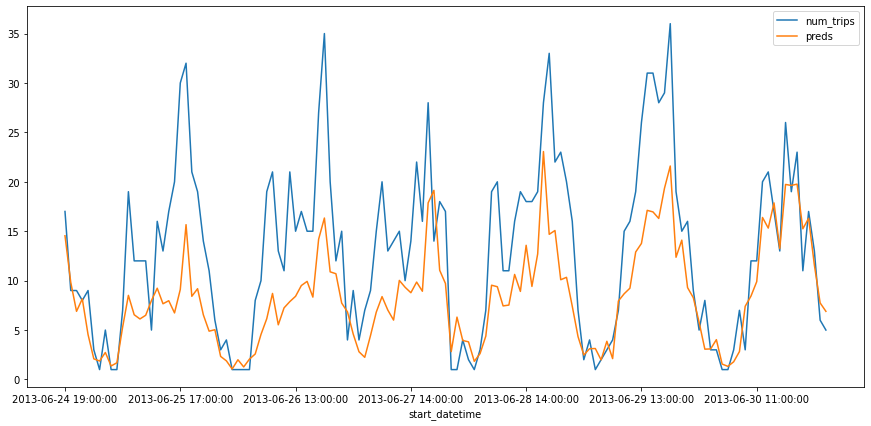

In [34]:
# Plot of max_station
max_station_df.plot(x='start_datetime', y=['num_trips', 'preds'], figsize=(15,7))

<AxesSubplot:xlabel='start_datetime'>

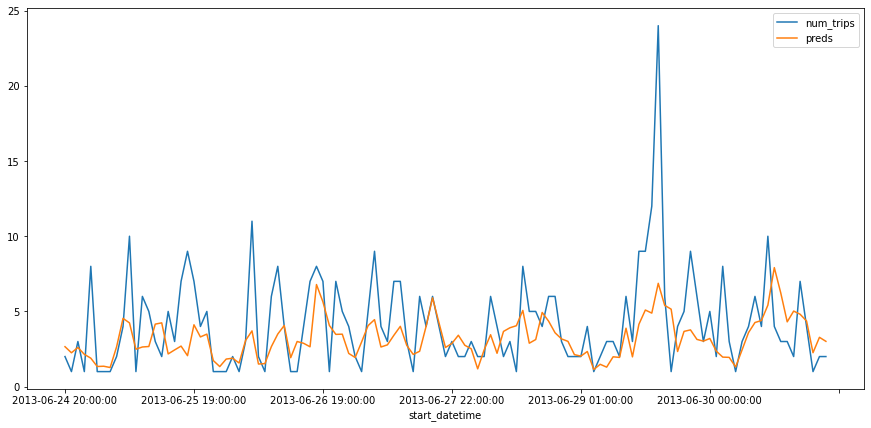

In [35]:
# Plot of median_station
median_station_df.plot(x='start_datetime', y=['num_trips', 'preds'], figsize=(15,7))